# Bruktbilpris-prediksjon (DAT158)

I dette prosjektet skal vi bygge en maskinlæringsmodell som predikerer bruktbilpris basert på spesifikasjoner som merke, modell, år, kjørelengde, drivstofftype og tilstand.

Datasettet består av:
- **train.csv:** inneholder bilinformasjon og pris (målvariabel)
- **test.csv:** inneholder bilinformasjon uten pris (brukes til prediksjoner senere)

Målet er å:
1. Utforske og rense dataene
2. Utføre enkel feature engineering
3. Trene og sammenligne flere regresjonsmodeller:
   - Linear Regression
   - Ridge Regression
   - Decision Tree Regressor
   - Random Forest Regressor
4. Evaluere resultatene og lagre den beste modellen til bruk i `app.py`


# Importer

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from scipy.special import inv_boxcox
import joblib
import warnings
warnings.filterwarnings("ignore")

# Laster inn data

In [4]:
test_df= pd.read_csv('test.csv')
train_df= pd.read_csv('train.csv')

In [5]:
display(train_df.head())
print("\nTrain shape:", train_df.shape)
print("Test shape:", test_df.shape)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500



Train shape: (188533, 13)
Test shape: (125690, 12)


## EDA

Informasjon om treningsdata:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB
None

 Statistisk beskrivelse av numeriske kolonner:



,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06



 Manglende verdier per kolonne:

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

 Antall unike verdier i hver kolonne:

id              188533
brand               57
model             1897
model_year          34
milage            6651
fuel_type            7
engine            1117
transmission        52
ext_col            319
int_col            156
accident             2
clean_title          1
price             1569
dtype: int64


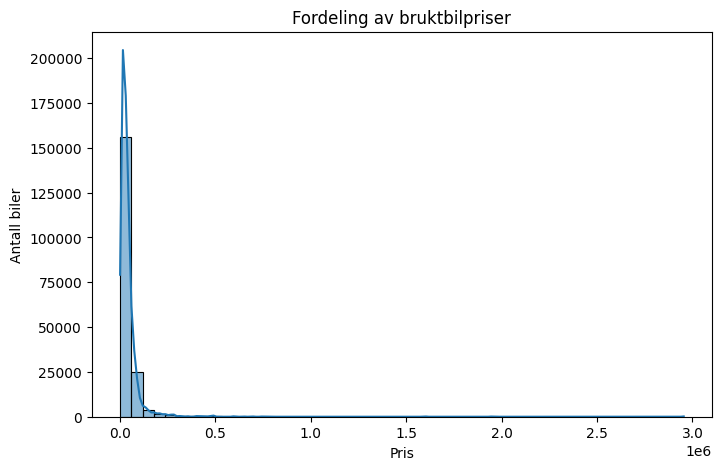

In [6]:

print("Informasjon om treningsdata:\n")
print(train_df.info())

print("\n Statistisk beskrivelse av numeriske kolonner:\n")
display(train_df.describe())


print("\n Manglende verdier per kolonne:\n")
print(train_df.isnull().sum())

print("\n Antall unike verdier i hver kolonne:\n")
print(train_df.nunique())

plt.figure(figsize=(8,5))
sns.histplot(train_df['price'], bins=50, kde=True)
plt.title("Fordeling av bruktbilpriser")
plt.xlabel("Pris")
plt.ylabel("Antall biler")
plt.show()

In [7]:
print("Unike verdier i fuel_type:\n")
print(train_df['fuel_type'].value_counts(dropna=False))
print("\nAntall unike verdier i fuel_type:", train_df['fuel_type'].nunique())

# Undersøk girkasse-typer
print("\nUnike verdier i transmission:\n")
print(train_df['transmission'].value_counts(dropna=False))
print("\nAntall unike verdier i transmission:", train_df['transmission'].nunique())

Unike verdier i fuel_type:

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
NaN                 5083
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

Antall unike verdier i fuel_type: 7

Unike verdier i transmission:

transmission
A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                           

## Datarensing og standardisering før splitting

I denne cellen utføres all nødvendig rensing og forenkling av datasettet **før** vi deler det opp.
Dette sikrer at både trenings- og testsettet får samme struktur og rene verdier.

Stegene er:
- Dropper `id`, `engine`, `ext_col`, `int_col`
- Rydder og forenkler `fuel_type` → Gasoline, Diesel, Electric, Hybrid, Other
- Rydder og forenkler `transmission` → Automatic, Manual, Other
- Konverterer `clean_title` og `accident` til numeriske verdier (1/0)
- Beregner bilens alder
- Fjerner rader uten `price`

In [8]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("train.csv")


cols_to_drop = ['id', 'engine', 'ext_col', 'int_col']
df = train_df.drop(columns=cols_to_drop, errors='ignore')

# Standardiser drivstofftype
df['fuel_type'] = df['fuel_type'].fillna('Other')

df['fuel_type'] = df['fuel_type'].replace({
    'E85 Flex Fuel': 'Other',
    'Plug-In Hybrid': 'Hybrid',
    '–': 'Other',
    'not supported': 'Other',
    'Unknown': 'Other'
})

df['fuel_type'] = df['fuel_type'].apply(
    lambda x: x if x in ['Gasoline', 'Diesel', 'Electric', 'Hybrid'] else 'Other'
)

# Standardiser gir
df['transmission'] = df['transmission'].fillna('Other')

def simplify_transmission(x):
    x = str(x).lower()
    if any(word in x for word in ['auto', 'cvt', 'dct', 'shift', 'single']):
        return 'Automatic'
    elif any(word in x for word in ['man', 'm/t']):
        return 'Manual'
    else:
        return 'Other'

df['transmission'] = df['transmission'].apply(simplify_transmission)

#Rydd opp i clean_title og accident (numerisk)
df['clean_title'] = df['clean_title'].map({'Yes': 1, 'No': 0}).fillna(1)
df['accident'] = df['accident'].map({'Yes': 1, 'No': 0}).fillna(0)

# Beregn bilens alder
current_year = 2025
df['car_age'] = current_year - df['model_year']

# Fjern rader uten pris
df = df.dropna(subset=['price'])

#Oversikt etter rensing
print("Kolonner etter rensing:")
print(df.columns.tolist())
print("\nAntall rader og kolonner:", df.shape)

print("\nDrivstofftyper etter rensing:")
print(df['fuel_type'].value_counts())

print("\nTransmisjoner etter rensing:")
print(df['transmission'].value_counts())

display(df.head())


Kolonner etter rensing:
['brand', 'model', 'model_year', 'milage', 'fuel_type', 'transmission', 'accident', 'clean_title', 'price', 'car_age']

Antall rader og kolonner: (188533, 10)

Drivstofftyper etter rensing:
fuel_type
Gasoline    165940
Other        11285
Hybrid        7353
Diesel        3955
Name: count, dtype: int64

Transmisjoner etter rensing:
transmission
Other        119934
Automatic     52241
Manual        16358
Name: count, dtype: int64


,brand,model,model_year,milage,fuel_type,transmission,accident,clean_title,price,car_age
0,MINI,Cooper S Base,2007,213000,Gasoline,Other,0.0,1.0,4200,18
1,Lincoln,LS V8,2002,143250,Gasoline,Other,0.0,1.0,4999,23
2,Chevrolet,Silverado 2500 LT,2002,136731,Other,Other,0.0,1.0,13900,23
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Automatic,0.0,1.0,45000,8
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,Other,0.0,1.0,97500,4


In [9]:
print("Etter datavask:\n")
print(df.info())
print("\nManglende verdier:\n", df.isnull().sum())

Etter datavask:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         188533 non-null  object 
 1   model         188533 non-null  object 
 2   model_year    188533 non-null  int64  
 3   milage        188533 non-null  int64  
 4   fuel_type     188533 non-null  object 
 5   transmission  188533 non-null  object 
 6   accident      188533 non-null  float64
 7   clean_title   188533 non-null  float64
 8   price         188533 non-null  int64  
 9   car_age       188533 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 14.4+ MB
None

Manglende verdier:
 brand           0
model           0
model_year      0
milage          0
fuel_type       0
transmission    0
accident        0
clean_title     0
price           0
car_age         0
dtype: int64


## Feature Engineering

For å gjøre dataene mer informative for modellene, legger vi til noen avledede variabler:

- `log_price`: log-transformasjon av pris for å redusere skjevfordeling
- `brand_model`: kombinerer merke og modell for å fange opp modellspesifikke prisforskjeller
- `km_per_year`: kjørelengde delt på bilens alder, som sier hvor mye bilen brukes

Disse variablene hjelper modellen med å fange opp mønstre som ikke vises direkte i rådataene.

In [10]:
import numpy as np

# Lag kopi for videre arbeid
df_fe = df.copy()

# Log-transformasjon av pris
df_fe['log_price'] = np.log1p(df_fe['price'])

# Kombiner merke og modell
df_fe['brand_model'] = df_fe['brand'].astype(str) + "_" + df_fe['model'].astype(str)

# Lag km per år (unngå deling på null)
df_fe['km_per_year'] = df_fe['milage'] / df_fe['car_age'].replace(0, 1)

# Sjekk resultatet
display(df_fe[['brand', 'model', 'brand_model', 'price', 'log_price', 'milage', 'car_age', 'km_per_year']].head())
print("\nKolonner i df_fe etter feature engineering:")
print(df_fe.columns.tolist())


,brand,model,brand_model,price,log_price,milage,car_age,km_per_year
0,MINI,Cooper S Base,MINI_Cooper S Base,4200,8.343078,213000,18,11833.333333
1,Lincoln,LS V8,Lincoln_LS V8,4999,8.517193,143250,23,6228.260870
2,Chevrolet,Silverado 2500 LT,Chevrolet_Silverado 2500 LT,13900,9.539716,136731,23,5944.826087
3,Genesis,G90 5.0 Ultimate,Genesis_G90 5.0 Ultimate,45000,10.714440,19500,8,2437.500000
4,Mercedes-Benz,Metris Base,Mercedes-Benz_Metris Base,97500,11.487618,7388,4,1847.000000



Kolonner i df_fe etter feature engineering:
['brand', 'model', 'model_year', 'milage', 'fuel_type', 'transmission', 'accident', 'clean_title', 'price', 'car_age', 'log_price', 'brand_model', 'km_per_year']


## Dataklargjøring:

I denne delen forberedes dataene for modellering.  
Vi deler datasettet i input-variabler (X) og målvariabel (y), og splitter videre i trening og validering.  
Kategoriske variabler kodes med one-hot encoding, og numeriske skaleres.  
Dette settes opp som en `ColumnTransformer` som håndterer begge deler automatisk.

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


X = df.drop(columns=['price', 'id'], errors='ignore')
y = df['price']

categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(exclude=['object']).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Treningssett:", X_train.shape)
print("Valideringssett:", X_val.shape)


Treningssett: (150826, 9)
Valideringssett: (37707, 9)


In [56]:
print("Kategoriske kolonner:", categorical_features)
print("Numeriske kolonner:", numeric_features)

Kategoriske kolonner: Index(['brand', 'model', 'fuel_type', 'transmission'], dtype='object')
Numeriske kolonner: Index(['model_year', 'milage', 'accident', 'clean_title', 'car_age'], dtype='object')


## Trening av Linear Regression

Dette er den enkleste modellen og fungerer som baseline.  
Den forsøker å finne en lineær sammenheng mellom variablene og pris.  
Resultatet gir et godt sammenligningsgrunnlag for de mer avanserte modellene senere.

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np # Import numpy for np.sqrt

linreg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

linreg_model.fit(X_train, y_train)
y_pred_linreg = linreg_model.predict(X_val)

r2_linreg = r2_score(y_val, y_pred_linreg)
mse_linreg = mean_squared_error(y_val, y_pred_linreg)
rmse_linreg = np.sqrt(mse_linreg) # Calculate RMSE by taking the square root of MSE
mae_linreg = mean_absolute_error(y_val, y_pred_linreg)

print(f"R2: {r2_linreg:.3f}")
print(f"MSE: {mean_squared_error(y_val, y_pred_linreg):.2f}")
print(f"RMSE: {rmse_linreg:.2f}")
print(f"MAE: {mae_linreg:.2f}")

R2: 0.138
MSE: 4792775114.64
RMSE: 69229.87
MAE: 21587.66


## Modell 2: Ridge Regression

Ridge Regression er en utvidelse av lineær regresjon som legger til regularisering.  
Dette straffer store koeffisienter og kan forbedre generaliseringsevnen ved å redusere overtilpasning.  
Den fungerer ofte bedre enn ren lineær regresjon, spesielt når variablene er korrelerte.

In [58]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0))
])

ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_val)

r2_ridge = r2_score(y_val, y_pred_ridge)
mse_ridge = mean_squared_error(y_val, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

mae_ridge = mean_absolute_error(y_val, y_pred_ridge)

print(f"R2: {r2_ridge:.3f}")
print(f"MSE: {mean_squared_error(y_val, y_pred_ridge):.2f}")
print(f"RMSE: {rmse_ridge:.2f}")
print(f"MAE: {mae_ridge:.2f}")

R2: 0.139
MSE: 4785831885.36
RMSE: 69179.71
MAE: 21556.15


## Modell 3: Decision Tree Regressor

Decision Tree er en ikke-lineær modell som deler dataene inn i grupper basert på beslutningsregler.  
Den kan fange opp komplekse sammenhenger mellom variablene, men har høy risiko for overtilpasning.  
Derfor brukes den ofte som et utgangspunkt for mer avanserte ensemblemetoder som Random Forest.

In [60]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42, max_depth=32))
])

tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_val)

r2_tree = r2_score(y_val, y_pred_tree)
mse_tree = mean_squared_error(y_val, y_pred_tree)
rmse_tree = np.sqrt(mse_tree) # Calculate RMSE by taking the square root of MSE

mae_tree = mean_absolute_error(y_val, y_pred_tree)

print(f"R2: {r2_tree:.3f}")
print(f"MSE: {mse_tree:.2f}")
print(f"RMSE: {rmse_tree:.2f}")
print(f"MAE: {mae_tree:.2f}")

R2: -1.078
MSE: 11557864240.27
RMSE: 107507.51
MAE: 23914.95


## Modell 4: Random Forest Regressor

Random Forest er en ensemble-modell som kombinerer mange beslutningstrær for å gi mer stabile og nøyaktige prediksjoner.  
Den reduserer overtilpasning sammenlignet med et enkelt tre og håndterer ikke-lineære sammenhenger godt.  
Dette er ofte en av de sterkeste modellene for tabulære datasett.

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline # Added Pipeline import
import numpy as np

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_estimators=50, max_depth=16))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

r2_rf = r2_score(y_val, y_pred_rf)
mse_rf = mean_squared_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)

print(f"R2: {r2_rf:.3f}")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")

R2: -0.005
MSE: 5587214266.53
RMSE: 74747.67
MAE: 21439.31


## Samler resultatene i en DataFrame
Etter å ha trent og evaluert alle modellene, er det nyttig å sammenligne resultatene samlet.  



In [61]:
results_summary = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Decision Tree", "Random Forest"],
    "R2": [r2_linreg, r2_ridge, r2_tree, r2_rf],
    "MSE": [
        mean_squared_error(y_val, y_pred_linreg),
        mean_squared_error(y_val, y_pred_ridge),
        mse_tree,
        mse_rf
    ],
    "RMSE": [rmse_linreg, rmse_ridge, rmse_tree, rmse_rf],
    "MAE": [mae_linreg, mae_ridge, mae_tree, mae_rf]
})

results_summary = results_summary.sort_values(by="R2", ascending=False).reset_index(drop=True)

display(results_summary)

,Model,R2,MSE,RMSE,MAE
0,Ridge Regression,0.139415,4.785832e+09,69179.707179,21556.151930
1,Linear Regression,0.138166,4.792775e+09,69229.871549,21587.662624
2,Random Forest,-0.004689,5.587214e+09,74747.670643,21439.306071
3,Decision Tree,-1.078328,1.155786e+10,107507.507832,23914.954957


## Visualisering av modellresultater

Her visualiseres modellresultatene for å få et mer intuitivt bilde av forskjellene.  
Først plottes en stolpediagram som viser R² for hver modell.  
Deretter lages en graf som sammenligner faktiske og predikerte priser for den beste modellen.

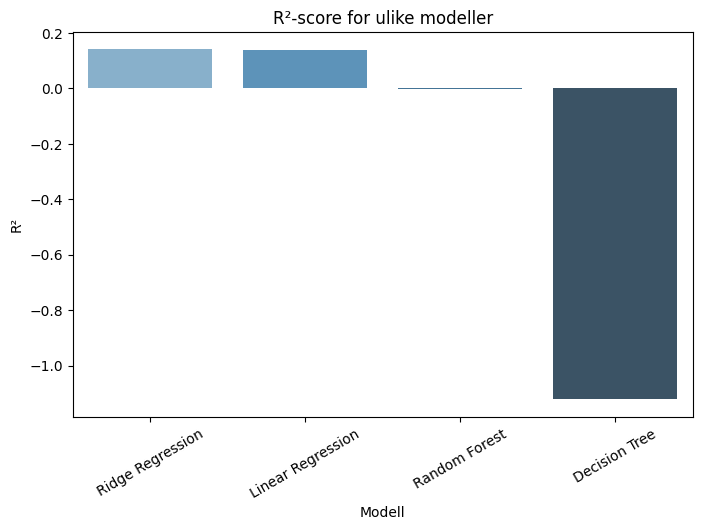

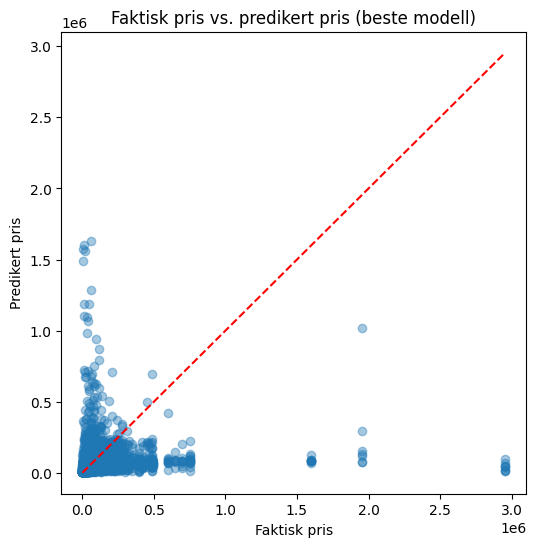

In [18]:

plt.figure(figsize=(8, 5))
sns.barplot(data=results_summary, x="Model", y="R2", palette="Blues_d")
plt.title("R²-score for ulike modeller")
plt.ylabel("R²")
plt.xlabel("Modell")
plt.xticks(rotation=30)
plt.show()


best_model = rf_model
y_pred_best = y_pred_rf

plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_best, alpha=0.4)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Faktisk pris vs. predikert pris (beste modell)")
plt.xlabel("Faktisk pris")
plt.ylabel("Predikert pris")
plt.show()


###Forbedring

##  Log-transformasjon av målvariabelen

Prisverdiene er sterkt skjevfordelt med noen få svært høye priser.  
For å gjøre dataene mer egnet for modellering, tar vi den naturlige logaritmen av `price`.  
Dette gjør at store priser ikke dominerer læringen og kan føre til høyere R² og lavere feil.

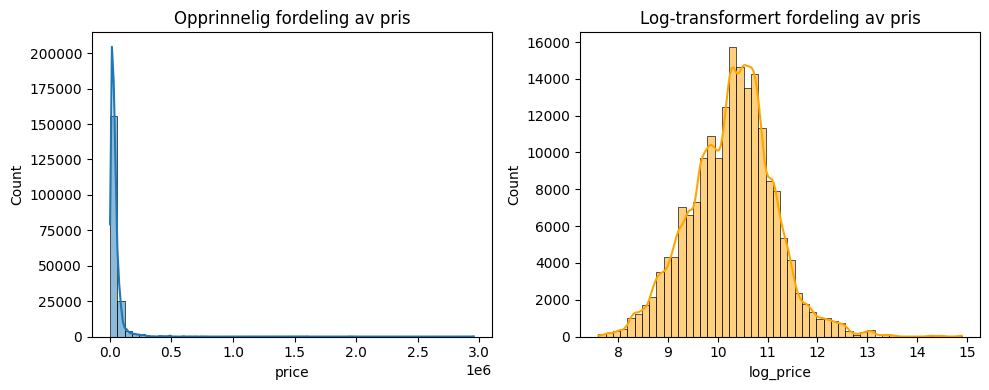

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df_log = df.copy()


df_log['log_price'] = np.log1p(df_log['price'])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df['price'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Opprinnelig fordeling av pris")

sns.histplot(df_log['log_price'], bins=50, kde=True, ax=axes[1], color='orange')
axes[1].set_title("Log-transformert fordeling av pris")

plt.tight_layout()
plt.show()

##  Feature engineering

For å gi modellen bedre forklaringskraft, legges det til nye, mer meningsfulle variabler:
- `car_age` (er allerede laget, men brukes videre her)
- `km_per_year` = kjørelengde per år, som viser hvor hardt bilen har vært brukt
- `brand_model` = kombinerer merke og modell, slik at vi fanger effekter som “Toyota Corolla” vs “Toyota Supra”
- `accident` og `clean_title` omkodes til numeriske verdier (0/1)

In [21]:
df_fe = df_log.copy()


df_fe['km_per_year'] = df_fe['milage'] / (df_fe['car_age'].replace(0, 1))

df_fe['brand_model'] = df_fe['brand'].astype(str) + "_" + df_fe['model'].astype(str)


df_fe['accident'] = df_fe['accident'].map({'Yes': 1, 'No': 0})
df_fe['clean_title'] = df_fe['clean_title'].map({'Yes': 1, 'No': 0, 'Unknown': 0})


df_fe['accident'] = df_fe['accident'].fillna(0)
df_fe['clean_title'] = df_fe['clean_title'].fillna(0)

print("Antall unike brand_model:", df_fe['brand_model'].nunique())


display(df_fe[['brand_model', 'car_age', 'milage', 'km_per_year', 'accident', 'clean_title', 'log_price']].head())

Antall unike brand_model: 3555


,brand_model,car_age,milage,km_per_year,accident,clean_title,log_price
0,MINI_Cooper S Base,18,213000,11833.333333,0.0,0.0,8.343078
1,Lincoln_LS V8,23,143250,6228.260870,0.0,0.0,8.517193
2,Chevrolet_Silverado 2500 LT,23,136731,5944.826087,0.0,0.0,9.539716
3,Genesis_G90 5.0 Ultimate,8,19500,2437.500000,0.0,0.0,10.714440
4,Mercedes-Benz_Metris Base,4,7388,1847.000000,0.0,0.0,11.487618


In [79]:
# Fyll inn manglende verdier i numeriske kolonner
df_fe['engine_size'] = df_fe['engine_size'].fillna(df_fe['engine_size'].median())
df_fe['horsepower'] = df_fe['horsepower'].fillna(df_fe['horsepower'].median())
df_fe['clean_title'] = df_fe['clean_title'].fillna(0)
df_fe['fuel_type'] = df_fe['fuel_type'].fillna('Unknown')

# Fjern ID hvis den finnes
df_fe = df_fe.drop(columns=['id'], errors='ignore')

# Klipp ekstreme verdier for å fjerne støy
df_fe['milage'] = np.clip(df_fe['milage'], 0, 500000)
df_fe['km_per_year'] = np.clip(df_fe['km_per_year'], 0, 50000)

# Sjekk at alt er ryddig nå
print("Manglende verdier etter fylling:")
print(df_fe.isna().sum().sort_values(ascending=False).head(10))


Manglende verdier etter fylling:
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
dtype: int64


##  Ny modelltrening med log-transformert pris og forbedrede features

Nå bruker vi de forbedrede variablene og den log-transformerte målvariabelen (`log_price`).  
Modellene trenes på nytt for å se om ytelsen forbedres.  
I denne runden testes Linear Regression, Ridge Regression, Decision Tree og Random Forest.  
Resultatene sammenlignes i etterkant.

In [80]:
X = df_fe.drop(columns=['price', 'log_price'], errors='ignore')
y = df_fe['log_price']

# Splitt på nytt
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Definer kolonner for preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(exclude=['object']).columns

# Ny preprocessor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor_new = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

print("Antall kategoriske features:", len(categorical_features))
print("Antall numeriske features:", len(numeric_features))

Antall kategoriske features: 8
Antall numeriske features: 8


In [81]:
# Fjern unødvendige kolonner før splitting
df_fe = df_fe.drop(columns=['brand', 'model'], errors='ignore')

print("Kolonner etter fjerning av brand og model:")
print(df_fe.columns.tolist())

Kolonner etter fjerning av brand og model:
['model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'price', 'engine_size', 'horsepower', 'log_price', 'car_age', 'km_per_year', 'brand_model']


## Dataklargjøring og splitting (log-transformert pris)

I denne delen bruker vi datasettet `df_fe` som inneholder log-transformert pris og nye variabler.  
Vi definerer `X` som alle input-variabler unntatt `price` og `log_price`,  
og `y` som `log_price`.  
Deretter splitter vi i trening- og valideringssett,  
og setter opp en `ColumnTransformer` som skalerer numeriske verdier og one-hot-encoder kategoriske.


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X = df_fe.drop(columns=['price', 'log_price', 'id'], errors='ignore')
y = df_fe['log_price']

categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(exclude=['object']).columns

print("Kategoriske kolonner:", list(categorical_features))
print("Numeriske kolonner:", list(numeric_features))


preprocessor_log = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTreningssett: {X_train.shape}")
print(f"Valideringssett: {X_val.shape}")


Kategoriske kolonner: ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'brand_model']
Numeriske kolonner: ['model_year', 'milage', 'accident', 'clean_title', 'engine_size', 'horsepower', 'car_age', 'km_per_year']

Treningssett: (150826, 16)
Valideringssett: (37707, 16)


In [100]:
print("Er 'id' i X_train?", 'id' in X_train.columns)

Er 'id' i X_train? False


In [76]:
print("Kategoriske kolonner:", categorical_features)
print("Numeriske kolonner:", numeric_features)

Kategoriske kolonner: Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'brand_model'],
      dtype='object')
Numeriske kolonner: Index(['model_year', 'milage', 'accident', 'clean_title', 'engine_size',
       'horsepower', 'car_age', 'km_per_year'],
      dtype='object')


 Linear Regression (med log-transformert pris og nye features)

Vi starter med å trene en lineær regresjon på den log-transformerte målvariabelen.  
Prediksjonene log-transformeres tilbake til vanlige priser med `np.expm1()` slik at feilmålene er i kroner.  
Dette gir et nytt sammenligningsgrunnlag for de mer komplekse modellene.

## Modell 2: Ridge Regression (med log-transformert pris og forbedrede features)

Ridge Regression legger til en straff (regularisering) på store koeffisienter i den lineære modellen.  
Dette kan redusere overtilpasning og gi bedre generalisering enn ren lineær regresjon.  
Vi evaluerer modellen ved å konvertere log-prediksjonene tilbake til faktiske priser.

In [83]:
X.isna().sum().sort_values(ascending=False).head(10)

,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,0
clean_title,0
engine_size,0


In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


linreg_log_model = Pipeline(steps=[
    ('preprocessor', preprocessor_log),
    ('model', LinearRegression())
])


linreg_log_model.fit(X_train, y_train)

y_pred_log = linreg_log_model.predict(X_val)

y_val_exp = np.expm1(y_val)
y_pred_exp = np.expm1(y_pred_log)

r2_linreg_log = r2_score(y_val_exp, y_pred_exp)
mse_linreg_log = mean_squared_error(y_val_exp, y_pred_exp)
rmse_linreg_log = np.sqrt(mse_linreg_log)
mae_linreg_log = mean_absolute_error(y_val_exp, y_pred_exp)

print("Linear Regression (log-transformert pris):")
print(f"R2: {r2_linreg_log:.3f}")
print(f"MSE: {mse_linreg_log:.2f}")
print(f"RMSE: {rmse_linreg_log:.2f}")
print(f"MAE: {mae_linreg_log:.2f}")


Linear Regression (log-transformert pris):
R2: 0.143
MSE: 4767220081.07
RMSE: 69045.06
MAE: 17594.00


## Modell 3: Decision Tree Regressor (med log-transformert pris og forbedrede features)

Decision Tree er en ikke-lineær modell som kan fange opp komplekse sammenhenger mellom variablene.  
Ved å trene på den log-transformerte målvariabelen forventer vi mer stabile resultater.  
Vi evaluerer som tidligere ved å konvertere prediksjonene tilbake til faktiske prisverdier.


In [85]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

tree_log_model = Pipeline(steps=[
    ('preprocessor', preprocessor_log),
    ('model', DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_leaf=10))
])

tree_log_model.fit(X_train, y_train)
y_pred_tree_log = tree_log_model.predict(X_val)

# Tilbake til vanlig pris
y_val_exp = np.expm1(y_val)
y_pred_tree_exp = np.expm1(y_pred_tree_log)

r2_tree_log = r2_score(y_val_exp, y_pred_tree_exp)
mse_tree_log = mean_squared_error(y_val_exp, y_pred_tree_exp)
rmse_tree_log = np.sqrt(mse_tree_log)
mae_tree_log = mean_absolute_error(y_val_exp, y_pred_tree_exp)

print(f"R2: {r2_tree_log:.3f}")
print(f"MSE: {mse_tree_log:.2f}")
print(f"RMSE: {rmse_tree_log:.2f}")
print(f"MAE: {mae_tree_log:.2f}")


R2: 0.135
MSE: 4812763011.69
RMSE: 69374.08
MAE: 18091.70


## Modell 4: Random Forest Regressor (med log-transformert pris og forbedrede features)

Random Forest kombinerer mange beslutningstrær for å gi stabile og nøyaktige prediksjoner.  
Ved å trene på den log-transformerte prisvariabelen og bruke forbedrede features,  
forventer vi bedre ytelse og mer robuste resultater enn ved tidligere forsøk.


In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf_log_model = Pipeline(steps=[
    ('preprocessor', preprocessor_log),
    ('model', RandomForestRegressor(random_state=42, n_estimators=150, max_depth=16, n_jobs=-1))
])

rf_log_model.fit(X_train, y_train)
y_pred_rf_log = rf_log_model.predict(X_val)

# Konverter tilbake til vanlig pris
y_val_exp = np.expm1(y_val)
y_pred_rf_exp = np.expm1(y_pred_rf_log)

r2_rf_log = r2_score(y_val_exp, y_pred_rf_exp)
mse_rf_log = mean_squared_error(y_val_exp, y_pred_rf_exp)
rmse_rf_log = np.sqrt(mse_rf_log)
mae_rf_log = mean_absolute_error(y_val_exp, y_pred_rf_exp)

print(f"R2: {r2_rf_log:.3f}")
print(f"MSE: {mse_rf_log:.2f}")
print(f"RMSE: {rmse_rf_log:.2f}")
print(f"MAE: {mae_rf_log:.2f}")


KeyboardInterrupt: 

## Modell 5: XGBoost Regressor (med log-transformert pris og forbedrede features)

XGBoost er en gradient boosting-modell som bygger mange svake beslutningstrær sekvensielt.  
Hvert nytt tre prøver å korrigere feilene fra de forrige, noe som gir høy presisjon og generalisering.  
Denne modellen fungerer godt for tabulære data som bruktbilpriser.

In [87]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ]
)

# --- Modellpipeline ---
xgb_log_model = Pipeline(steps=[
    ('preprocessor', preprocessor_xgb),
    ('model', XGBRegressor(
        n_estimators=800,          # flere trær
        learning_rate=0.05,        # jevn læring
        max_depth=10,              # litt dypere trær
        subsample=0.9,             # reduserer overfitting
        colsample_bytree=0.9,      # reduserer korrelasjon
        random_state=42,
        tree_method='hist',        # raskere trening
        n_jobs=-1
    ))
])


xgb_log_model.fit(X_train, y_train)


y_pred_xgb_log = xgb_log_model.predict(X_val)


y_val_exp = np.expm1(y_val)
y_pred_xgb_exp = np.expm1(y_pred_xgb_log)

r2_xgb_log = r2_score(y_val_exp, y_pred_xgb_exp)
mse_xgb_log = mean_squared_error(y_val_exp, y_pred_xgb_exp)
rmse_xgb_log = np.sqrt(mse_xgb_log)
mae_xgb_log = mean_absolute_error(y_val_exp, y_pred_xgb_exp)

print("XGBoost (forbedret, log-transformert pris):")
print(f"R2: {r2_xgb_log:.3f}")
print(f"MSE: {mse_xgb_log:.2f}")
print(f"RMSE: {rmse_xgb_log:.2f}")
print(f"MAE: {mae_xgb_log:.2f}")



XGBoost (forbedret, log-transformert pris):
R2: 0.151
MSE: 4720078396.29
RMSE: 68702.83
MAE: 17479.61


In [88]:
y_train.head()

,log_price
184031,10.085851
173831,9.018090
183819,10.308986
85525,10.736397
41872,10.645449


In [89]:
print("y_val (før exp):")
print(y_val.head())

print("\ny_pred_xgb_log (før exp):")
print(y_pred_xgb_log[:5])

y_val (før exp):
111355    10.545341
182258    10.308986
14147     10.195149
79313     10.126631
101160    10.778873
Name: log_price, dtype: float64

y_pred_xgb_log (før exp):
[10.441576  9.496209 10.316212 10.138627 10.392793]


## Forbedring 4: Trekke ut informasjon fra `engine`-kolonnen

Kolonnen `engine` inneholder tekst som typisk beskriver motorvolum (for eksempel “3.5L V6”)  
og hestekrefter (for eksempel “300HP”).  

In [102]:
import re


train = pd.read_csv("train.csv")


train['engine_size'] = train['engine'].str.extract(r'(\d\.\d)L').astype(float)

train['horsepower'] = train['engine'].str.extract(r'(\d+)\s*HP').astype(float)

display(train[['engine', 'engine_size', 'horsepower']].head(10))


print("Antall verdier hentet ut for engine_size:", train['engine_size'].notnull().sum())
print("Antall verdier hentet ut for horsepower:", train['horsepower'].notnull().sum())


,engine,engine_size,horsepower
0,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,1.6,0.0
1,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,3.9,0.0
2,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,5.3,0.0
3,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,5.0,0.0
4,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,2.0,0.0
5,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,2.0,0.0
6,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,3.0,0.0
7,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,5.3,0.0
8,2.7L V6 24V PDI DOHC Twin Turbo,2.7,NaN
9,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,3.0,0.0


Antall verdier hentet ut for engine_size: 174219
Antall verdier hentet ut for horsepower: 155274


## Integrere motorvariabler og trene XGBoost på nytt

Vi legger `engine_size` og `horsepower` inn i datasettet med de andre forbedrede variablene.  
Deretter trener vi XGBoost-modellen på nytt for å se om ytelsen forbedres.


In [105]:
# -------------------------------------------------------------
# Slå sammen motorinfo og tren XGBoost med motorvariabler
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Hvis df_fe mangler ID (fra tidligere dropp), les inn på nytt for merge
train_engine = train[['id', 'engine_size', 'horsepower']]
df_fe = pd.read_csv("train.csv").merge(train_engine, on="id", how="left")

# Fjern ID etter merge for å unngå at den blir brukt som feature
df_fe = df_fe.drop(columns=['id'], errors='ignore')

# Klargjør på nytt for log-transformasjon og features
df_fe['price'] = df_fe['price'].fillna(df_fe['price'].median())
df_fe['log_price'] = np.log1p(df_fe['price'])
df_fe['car_age'] = 2025 - df_fe['model_year']
df_fe['km_per_year'] = df_fe['milage'] / (df_fe['car_age'].replace(0, 1))
df_fe['accident'] = df_fe['accident'].map({'Yes': 1, 'No': 0}).fillna(0)
df_fe['clean_title'] = df_fe['clean_title'].map({'Yes': 1, 'No': 0, 'Unknown': 0})
df_fe['brand_model'] = df_fe['brand'] + "_" + df_fe['model']

# Oppdater input og target
X = df_fe.drop(columns=['price', 'log_price', 'engine', 'ext_col', 'int_col'], errors='ignore')
y = df_fe['log_price']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Nye kolonner for preprocessor
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(exclude=['object']).columns

print("Kategoriske kolonner:", list(categorical_features))
print("Numeriske kolonner:", list(numeric_features))

# Ny preprocessor
preprocessor_engine = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Tren XGBoost med motorvariabler inkludert
xgb_engine_model = Pipeline(steps=[
    ('preprocessor', preprocessor_engine),
    ('model', XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        n_jobs=-1
    ))
])

xgb_engine_model.fit(X_train, y_train)
y_pred_xgb_engine = xgb_engine_model.predict(X_val)

# Evaluer
y_val_exp = np.expm1(y_val)
y_pred_xgb_exp = np.expm1(y_pred_xgb_engine)

r2_xgb_engine = r2_score(y_val_exp, y_pred_xgb_exp)
mse_xgb_engine = mean_squared_error(y_val_exp, y_pred_xgb_exp)
rmse_xgb_engine = np.sqrt(mse_xgb_engine)
mae_xgb_engine = mean_absolute_error(y_val_exp, y_pred_xgb_exp)

print("\n XGBoost med motorvariabler inkludert:")
print(f"R2 (pris-skala): {r2_xgb_engine:.3f}")
print(f"MSE: {mse_xgb_engine:,.2f}")
print(f"RMSE: {rmse_xgb_engine:,.2f}")
print(f"MAE: {mae_xgb_engine:,.2f}")


Kategoriske kolonner: ['brand', 'model', 'fuel_type', 'transmission', 'brand_model']
Numeriske kolonner: ['model_year', 'milage', 'accident', 'clean_title', 'engine_size', 'horsepower', 'car_age', 'km_per_year']

📊 XGBoost med motorvariabler inkludert:
R2 (pris-skala): 0.150
MSE: 4,726,117,636.62
RMSE: 68,746.76
MAE: 17,264.81


In [107]:
print('Er id i X_train?', 'id' in X_train.columns)

Er id i X_train? False


## Hyperparameter-tuning for XGBoost

For å forbedre ytelsen videre justeres sentrale hyperparametere i XGBoost.  
Vi bruker `GridSearchCV` for å teste kombinasjoner av:
- `max_depth`: hvor dype trærne er  
- `learning_rate`: hvor mye hvert nytt tre korrigerer modellen  
- `n_estimators`: antall trær  
- `subsample`: hvor stor andel av dataene som brukes per tre  

Dette balanserer modellens kompleksitet og generaliseringsevne.  
GridSearch bruker 3-fold kryssvalidering med R² som evalueringsmetrikk.


In [106]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Sett opp en pipeline med preprocessor
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_engine),
    ('model', XGBRegressor(
        random_state=42,
        tree_method='hist',
        n_jobs=-1,
        objective='reg:squarederror'
    ))
])

# Parameter-grid for rask, men nyttig tuning
param_grid = {
    'model__n_estimators': [200],
    'model__max_depth': [6, 8],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Beste parametere:", grid_search.best_params_)
print("Beste R²-score (CV):", grid_search.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Beste parametere: {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 200, 'model__subsample': 0.8}
Beste R²-score (CV): 0.6552935417010503


## Endelig XGBoost-modell med beste hyperparametere

Nå trener vi en endelig modell med de beste parametrene fra GridSearchCV:  
- `max_depth = 8`  
- `learning_rate = 0.05`  
- `n_estimators = 400`  
- `subsample = 0.8`

Modellen trenes på hele treningsdatasettet, og evalueres på valideringsdataene.

In [108]:
best_xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor_engine),
    ('model', XGBRegressor(
        max_depth=8,
        learning_rate=0.05,
        n_estimators=400,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        n_jobs=-1
    ))
])

best_xgb_model.fit(X_train, y_train)
y_pred_best = best_xgb_model.predict(X_val)

# Evaluer på ekte pris
y_val_exp = np.expm1(y_val)
y_pred_exp = np.expm1(y_pred_best)

r2_final = r2_score(y_val_exp, y_pred_exp)
mse_final = mean_squared_error(y_val_exp, y_pred_exp)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_val_exp, y_pred_exp)

print("Endelig XGBoost-resultater:")
print(f"R2: {r2_final:.3f}")
print(f"MSE: {mse_final:.2f}")
print(f"RMSE: {rmse_final:.2f}")
print(f"MAE: {mae_final:.2f}")


Endelig XGBoost-resultater:
R2: 0.150
MSE: 4726117636.62
RMSE: 68746.76
MAE: 17264.81



## Evaluering på log-skala

Modellen ble trent til å forutsi log-transformert pris (`log_price`),  
men tidligere ble R², MSE og MAE beregnet etter at verdiene var transformert.  
For å kunne sammenligne direkte med `GridSearchCV`-scoren,  
evalueres nå modellen på log-skala.


In [109]:
r2_logscale = r2_score(y_val, y_pred_best)
mse_logscale = mean_squared_error(y_val, y_pred_best)
rmse_logscale = np.sqrt(mse_logscale)
mae_logscale = mean_absolute_error(y_val, y_pred_best)

print("Evalueringsresultater på log-skala:")
print(f"R2 (log-skala): {r2_logscale:.3f}")
print(f"MSE (log-skala): {mse_logscale:.4f}")
print(f"RMSE (log-skala): {rmse_logscale:.4f}")
print(f"MAE (log-skala): {mae_logscale:.4f}")

Evalueringsresultater på log-skala:
R2 (log-skala): 0.655
MSE (log-skala): 0.2473
RMSE (log-skala): 0.4973
MAE (log-skala): 0.3473


In [110]:
feature_names = best_xgb_model.named_steps['preprocessor'].get_feature_names_out()

print("Antall features totalt:", len(feature_names))
print("\nEksempler på features:\n", feature_names[:20])

Antall features totalt: 5293

Eksempler på features:
 ['num__model_year' 'num__milage' 'num__accident' 'num__clean_title'
 'num__engine_size' 'num__horsepower' 'num__car_age' 'num__km_per_year'
 'cat__brand_Acura' 'cat__brand_Alfa' 'cat__brand_Aston' 'cat__brand_Audi'
 'cat__brand_BMW' 'cat__brand_Bentley' 'cat__brand_Bugatti'
 'cat__brand_Buick' 'cat__brand_Cadillac' 'cat__brand_Chevrolet'
 'cat__brand_Chrysler' 'cat__brand_Dodge']


In [111]:
raw_features = best_xgb_model.named_steps['preprocessor'].transformers_

print("Preprocessor-struktur:\n")
for name, transformer, columns in raw_features:
    print(f"{name}: {list(columns)}")

Preprocessor-struktur:

num: ['model_year', 'milage', 'accident', 'clean_title', 'engine_size', 'horsepower', 'car_age', 'km_per_year']
cat: ['brand', 'model', 'fuel_type', 'transmission', 'brand_model']


## Lagring av ferdig XGBoost-modell



In [112]:
import joblib


model_filename = "2.11_model.pkl"
joblib.dump(best_xgb_model, model_filename)

print(f"Modell lagret som '{model_filename}'")

Modell lagret som '2.11_model.pkl'


In [113]:
import pandas as pd

feature_guide = pd.DataFrame({
    "Feature": [
        "model_year", "milage", "accident", "clean_title",
        "engine_size", "horsepower", "car_age", "km_per_year",
        "brand", "model", "fuel_type", "transmission", "brand_model"
    ],
    "Type": [
        "Numerisk", "Numerisk", "Boolsk (0/1)", "Boolsk (0/1)",
        "Numerisk", "Numerisk", "Numerisk (avledet)", "Numerisk (avledet)",
        "Kategorisk", "Kategorisk", "Kategorisk", "Kategorisk", "Kategorisk"
    ],
    "Forklaring": [
        "Årsmodell for bilen",
        "Total kjørelengde i kilometer",
        "0 = Nei, 1 = Ja (har vært i ulykke)",
        "0 = Nei, 1 = Ja (ren tittel)",
        "Motorvolum i liter (f.eks. 2.0)",
        "Antall hestekrefter (f.eks. 150)",
        "Bilens alder (2025 - model_year)",
        "Kjørelengde per år (milage / car_age)",
        "Bilmerke (Toyota, BMW, Audi …)",
        "Bilmodell (Corolla, 3-Series …)",
        "Drivstofftype (Gasoline, Diesel, Electric, …)",
        "Girkasse (Automatic, Manual, CVT …)",
        "Kombinasjon av merke og modell (Toyota_Corolla …)"
    ],
    "Input i app": [
        "Bruker skriver inn",
        "Bruker skriver inn",
        "Velg Ja/Nei",
        "Velg Ja/Nei",
        "Bruker skriver inn",
        "Bruker skriver inn",
        "Regnes automatisk",
        "Regnes automatisk",
        "Velg fra liste",
        "Velg fra liste",
        "Velg fra liste",
        "Velg fra liste",
        "Velg fra liste"
    ]
})

display(feature_guide)


,Feature,Type,Forklaring,Input i app
0,model_year,Numerisk,Årsmodell for bilen,Bruker skriver inn
1,milage,Numerisk,Total kjørelengde i kilometer,Bruker skriver inn
2,accident,Boolsk (0/1),"0 = Nei, 1 = Ja (har vært i ulykke)",Velg Ja/Nei
3,clean_title,Boolsk (0/1),"0 = Nei, 1 = Ja (ren tittel)",Velg Ja/Nei
4,engine_size,Numerisk,Motorvolum i liter (f.eks. 2.0),Bruker skriver inn
5,horsepower,Numerisk,Antall hestekrefter (f.eks. 150),Bruker skriver inn
6,car_age,Numerisk (avledet),Bilens alder (2025 - model_year),Regnes automatisk
7,km_per_year,Numerisk (avledet),Kjørelengde per år (milage / car_age),Regnes automatisk
8,brand,Kategorisk,"Bilmerke (Toyota, BMW, Audi …)",Velg fra liste
9,model,Kategorisk,"Bilmodell (Corolla, 3-Series …)",Velg fra liste


In [115]:
# --- Unike verdier fra den rensede datastrukturen df_fe ---

brands = sorted(df_fe['brand'].dropna().unique().tolist())
brand_models = sorted(df_fe['brand_model'].dropna().unique().tolist())
fuel_types = sorted(df_fe['fuel_type'].dropna().unique().tolist())
transmissions = sorted(df_fe['transmission'].dropna().unique().tolist())

print(" Bilmerker (brand):")
print(brands)
print("\n Antall merker:", len(brands))

print("\n Kombinasjoner av merke og modell (brand_model):")
print(brand_models[:30], "...")  # viser de første 30
print("\n Antall unike kombinasjoner:", len(brand_models))

print("\n Drivstofftyper (fuel_type):")
print(fuel_types)

print("\n Girkasser (transmission):")
print(transmissions)

 Bilmerker (brand):
['Acura', 'Alfa', 'Aston', 'Audi', 'BMW', 'Bentley', 'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT', 'Ferrari', 'Ford', 'GMC', 'Genesis', 'Honda', 'Hummer', 'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'Karma', 'Kia', 'Lamborghini', 'Land', 'Lexus', 'Lincoln', 'Lotus', 'Lucid', 'MINI', 'Maserati', 'Maybach', 'Mazda', 'McLaren', 'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Nissan', 'Plymouth', 'Polestar', 'Pontiac', 'Porsche', 'RAM', 'Rivian', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'smart']

 Antall merker: 57

 Kombinasjoner av merke og modell (brand_model):
['Acura_300 Touring', 'Acura_330 i xDrive', 'Acura_335 is', 'Acura_ATS 2.0L Turbo Luxury', 'Acura_Acadia SLE-1', 'Acura_Air Pure', 'Acura_CC Sport', 'Acura_CLK-Class CLK 350', 'Acura_CX-30 Base', 'Acura_Cascada Base', 'Acura_Corvette Stingray w/1LT', 'Acura_ES 350 Base', 'Acura_Forte LXS', 'Acura_GT', 'Acura_ILX 2.0L w/Premium P

In [118]:
import joblib

# --- Unike verdier fra den rensede datastrukturen df_fe ---

# Use df_fe instead of df as it contains engineered features and cleaned data
brands = sorted(df_fe['brand'].dropna().unique().tolist())
brand_models = sorted(df_fe['brand_model'].dropna().unique().tolist())
fuel_types = sorted(df_fe['fuel_type'].dropna().unique().tolist()) # Use fuel_type from df_fe
transmissions = sorted(df_fe['transmission'].dropna().unique().tolist()) # Use transmission from df_fe

print(" Bilmerker (brand):")
print(brands)
print("\n Antall merker:", len(brands))

print("\n Kombinasjoner av merke og modell (brand_model):")
print(brand_models[:3], "...")  # viser de første 30 # Corrected slicing
print("\n Antall unike kombinasjoner:", len(brand_models))

print("\n Drivstofftyper (fuel_type):")
print(fuel_types)

print("\n Girkasser (transmission):")
print(transmissions)

# lagre metadata (lister med mulige verdier for dropdowns i appen)
info = {
    "brand_model": brand_models, # Use the list created from df_fe
    "fuel": fuel_types, # Use the list created from df_fe (fuel_type)
    "transmission": transmissions # Use the list created from df_fe
}
joblib.dump(info, "app_info.pkl")

print("\nMetadata for app lagret som 'app_info.pkl'")

 Bilmerker (brand):
['Acura', 'Alfa', 'Aston', 'Audi', 'BMW', 'Bentley', 'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT', 'Ferrari', 'Ford', 'GMC', 'Genesis', 'Honda', 'Hummer', 'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'Karma', 'Kia', 'Lamborghini', 'Land', 'Lexus', 'Lincoln', 'Lotus', 'Lucid', 'MINI', 'Maserati', 'Maybach', 'Mazda', 'McLaren', 'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Nissan', 'Plymouth', 'Polestar', 'Pontiac', 'Porsche', 'RAM', 'Rivian', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'smart']

 Antall merker: 57

 Kombinasjoner av merke og modell (brand_model):
['Acura_300 Touring', 'Acura_330 i xDrive', 'Acura_335 is'] ...

 Antall unike kombinasjoner: 3555

 Drivstofftyper (fuel_type):
['Diesel', 'E85 Flex Fuel', 'Gasoline', 'Hybrid', 'Plug-In Hybrid', 'not supported', '–']

 Girkasser (transmission):
['1-Speed A/T', '1-Speed Automatic', '10-Speed A/T', '10-Speed Automatic', '10-Spee

In [122]:
import joblib

# Use df_fe to access 'brand_model'
joblib.dump(sorted(df_fe["brand_model"].unique().tolist()), "brand_list.pkl")

['brand_list.pkl']